<a href="https://colab.research.google.com/github/ancastillar/ML_WORKSHOP/blob/main/Classification_task_ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Non-linear classification: Decision Tree & Random Forest
We first define some libraries and functions that we are going to use during the session:

In [ ]:
# https://pypi.python.org/pypi/pydot-
!apt install graphviz
!pip install graphviz
!pip install pydot

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
from sklearn import datasets
from sklearn.datasets import make_moons
import graphviz 
from sklearn.tree import export_graphviz
import pydot


# Function for displaying a 2D data set
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")
    
# Function for display of the decision surface of a classifier
def plot_decision_region(X, pred_fun):
    print(X.shape)
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 100)
    y_vals = np.linspace(min_y, max_y, 100)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    pl.contourf(XX, YY, ZZ, 100, cmap = pl.cm.coolwarm, vmin= -1, vmax=2)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")
    
def gen_pred_fun(clf):
    def pred_fun(x1, x2):
        x = np.array([[x1, x2]])
        return clf.predict(x)[0]
    return pred_fun

# Decision Trees

We presentnonlinear classification algorithm based on decision trees. Decision trees are very intuitive, since they encode a series of "**if this**" or "**if not then**" choices, much like a person would make a decision. The great advantage of this technique is that these choices can be learned automatically from the data.

## Example

Consider the following decision tree. This decision tree describes a series of choices that seek to determine whether to wait (**T**) or not (**F**) for a table in a restaurant.

<img src="https://github.com/fagonzalezo/iis-2020-1/raw/master/imgs/decisiontree2.png">

Based on the above decision tree, I can make the decision whether to wait or not, using some simple classification rules, e.g.:

*  **If** Customers = "Full" **AND** EstimatedWait = "10-30" **AND** Hungry = "No" **Then** Wait="YES"
* **If** Customers = "Some" **Then** Wait="YES"
*  **If** Clients = "Full" **Y** EstimatedWait = ">60" **Then** Wait="NO"

## Benefits

* Input data require very little preprocessing. Decision trees can work with variables of different types (continuous and variable) and are **invariant to feature scaling**. 
* Models are easy to interpret, trees can be visualized.
* The computational cost of using the tree to predict the category of an example is minimal compared to other techniques (Logarithmic time).

## Cons

* Can be so complex, that the data set is memorized, therefore does not generalize as well (**Overfitting**).
* Are very sensitive to class imbalance (**Bias**).

## How is the tree constructed? - Basic algorithm
* The tree is built from top to bottom recursively in a divide and conquer fashion.
* At the beginning, all training examples are at the root.
* Attributes are categorical (in case of continuous attributes, they are discretized in advance).
* The examples are distributed recursively according to the selected attribute. 
* Test attributes are selected based on a heuristic or statistical measure (e.g. **information gain**).
* Stops until there are only examples of one class in each leaf node or the maximum depth has been reached.


## How to select an attribute? How to measure if a partition is good?

An ideal partition is one that divides samples of the same class into a node. Let's see what happens if we use the variable **Client** to partition our dataset.

<img src="https://github.com/fagonzalezo/iis-2020-1/raw/master/imgs/split_clients.png">

Now, let's look at what happens when we partition the data set using the **Restaurant Type** variable.

<img src="https://github.com/fagonzalezo/iis-2020-1/raw/master/imgs/split_type.png">

**Which variable is better?**

## Implementation in Scikit-Learn

The implementation of Scikit-Learn is achieved with the `DecisionTreeClassifier` class.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion='entropy')

We loaded dataset using IRIS.


In [ ]:
iris = datasets.load_iris()
X = iris.data[:,[0, 2]] 
y = iris.target

`DecisionTreeClassifier` soporta varios parámetros como lo son:
* `max_depth`: Profundidad máxima del árbol.
* `criterion`: Medida para determinar la calidad del particionamiento generado por un atributo. Soporta coeficiente GINI y entropía.
* `min_samples_split`: Controla el número mínimo de muestras que debe haber en un nodo luego de una partición.
* `min_samples_leaf`: Controla el número mínimo de muestras que debe haber en un nodo hoja.

In [ ]:
help(DecisionTreeClassifier)

Help on class DecisionTreeClassifier in module sklearn.tree.tree:

class DecisionTreeClassifier(BaseDecisionTree, sklearn.base.ClassifierMixin)
 |  A decision tree classifier.
 |  
 |  Read more in the :ref:`User Guide <tree>`.
 |  
 |  Parameters
 |  ----------
 |  criterion : string, optional (default="gini")
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "entropy" for the information gain.
 |  
 |  splitter : string, optional (default="best")
 |      The strategy used to choose the split at each node. Supported
 |      strategies are "best" to choose the best split and "random" to choose
 |      the best random split.
 |  
 |  max_depth : int or None, optional (default=None)
 |      The maximum depth of the tree. If None, then nodes are expanded until
 |      all leaves are pure or until all leaves contain less than
 |      min_samples_split samples.
 |  
 |  min_samples_split : int, float, optional (default=2)

In [ ]:
classifier.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [ ]:
classifier = classifier.fit(X, y)

Visualizamos la superficie de decisión del clasificador

(150, 2)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


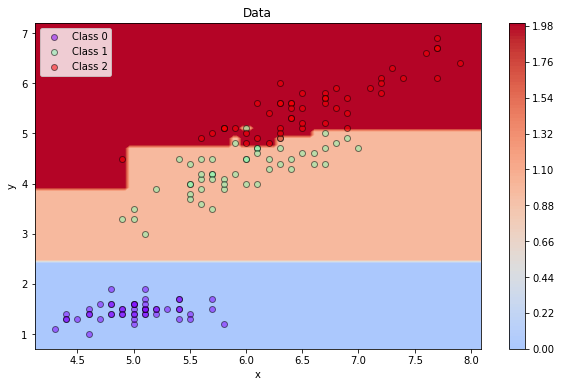

In [ ]:
pl.figure(figsize = (10, 6))    
plot_decision_region(X, gen_pred_fun(classifier))
plot_data(X, y)

In [ ]:
print('Error: {}'.format(1-classifier.score(X, y)))

Error: 0.00666666666666671


## Visualización

El árbol de decisión aprendido puede ser visualizado usando `graphviz`. En Ubuntu, se recomienda instalarlo usando ambas líneas:
* `conda install graphviz`
* `sudo apt-get install graphviz`

A continuación, vamos a usar el conjunto de datos IRIS completo (Usando las cuatro características) y entrenamos un árbol de decisión.

In [ ]:
X = iris.data
y = iris.target

classifier = DecisionTreeClassifier(criterion='entropy')
classifier = classifier.fit(X, y)

Usamos `graphviz` para visualizar el árbol generado. `graphviz` soporta como parámetros los nombres de las clases y de las características

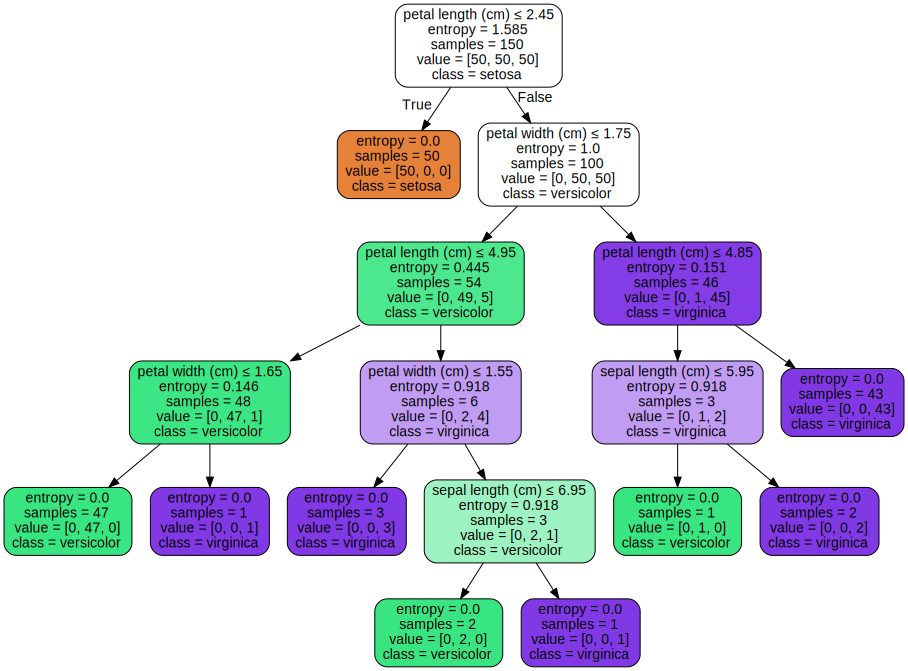

In [ ]:
from IPython.display import SVG
dot_data = export_graphviz(classifier, out_file=None, 
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)
SVG(graph.pipe(format='svg'))

## Importancia de las variables

Una de las ventajas de usar árboles de decisión, es que nos permite determinar la importancia de cada características, con base al índice de impureza usado. Scikit-Learn nos permite acceder a la importancia de cada característica llamando `.feature_importances_`. Esta importancia cuantifica qué tanto aporta cada característica a mejorar el desempeño del árbol.

In [ ]:
classifier.feature_importances_

array([0.02666667, 0.        , 0.05072262, 0.92261071])

In [ ]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

## Evaluación de la complejidad usando `DecisionTreeClassifier`

Para evaluar la complejidad, vamos a estimar la profundidad óptima del árbol.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, 
                                                    random_state=1234,
                                                    stratify=y)

Vamos a explorar los siguientes valores de profundidad máxima:
* $[1, 2, 3, \dots, 20]$

In [ ]:
train_error = []
generalization_error = []
max_depth_values = list(range(1, 21, 1))

for depth in max_depth_values:
    decision_tree = DecisionTreeClassifier(max_depth=depth)
    decision_tree.fit(X_train, y_train)
    train_error.append(1 - decision_tree.score(X_train, y_train))
    generalization_error.append(1 - decision_tree.score(X_test, y_test))

Visualizamos la curva de error de entrenamiento contra error de generalización

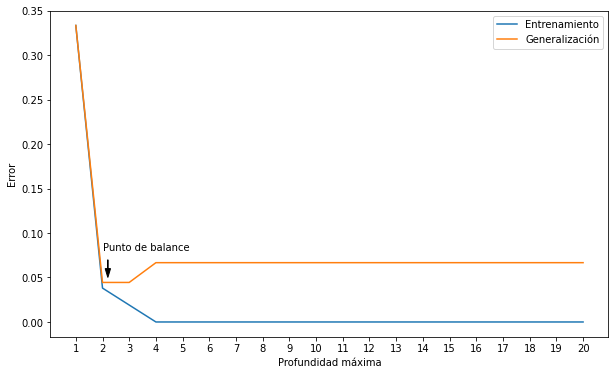

In [ ]:
pl.figure(figsize = (10, 6))

pl.plot(max_depth_values, train_error, label="Entrenamiento")
pl.plot(max_depth_values, generalization_error, label="Generalización")
pl.xticks(max_depth_values)
pl.xlabel("Profundidad máxima")
pl.ylabel("Error")
pl.arrow(2.2, 0.07, 0, -0.01, head_width=0.2, head_length=0.01, fc='k', ec='k')
pl.text(2, 0.08, 'Punto de balance')
pl.legend();

In [ ]:
X = iris.data
y = iris.target

classifier = DecisionTreeClassifier(criterion='entropy', max_depth=2)
classifier = classifier.fit(X, y)

Usamos `graphviz` para visualizar el árbol generado. `graphviz` soporta como parámetros los nombres de las clases y de las características

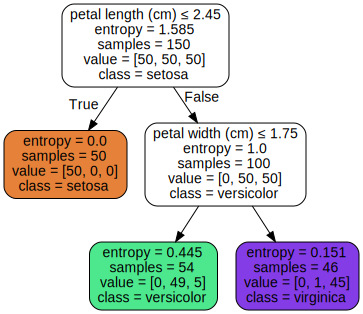

In [ ]:
from IPython.display import SVG
dot_data = export_graphviz(classifier, out_file=None, 
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)
SVG(graph.pipe(format='svg'))

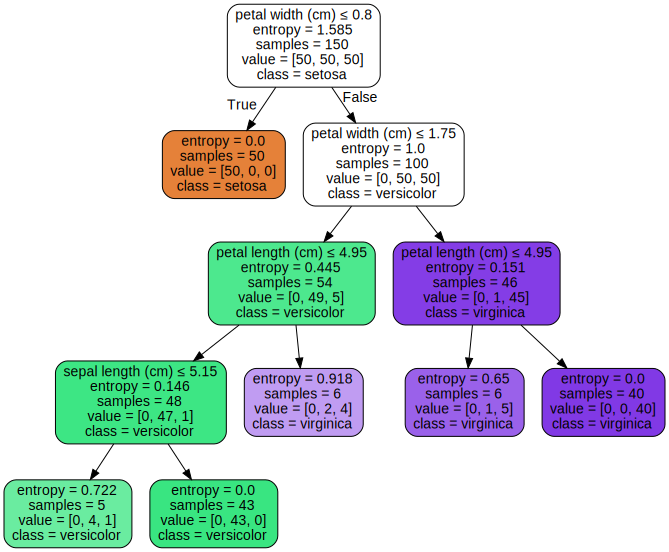

In [ ]:
X = iris.data
y = iris.target

classifier = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=5)
classifier = classifier.fit(X, y)

from IPython.display import SVG
dot_data = export_graphviz(classifier, out_file=None, 
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)
SVG(graph.pipe(format='svg'))

In [ ]:
train_error = []
generalization_error = []
min_samples_leaf_values = list(range(1, 21, 1))

for samples in min_samples_leaf_values:
    decision_tree = DecisionTreeClassifier(min_samples_leaf=samples)
    decision_tree.fit(X_train, y_train)
    train_error.append(1 - decision_tree.score(X_train, y_train))
    generalization_error.append(1 - decision_tree.score(X_test, y_test))

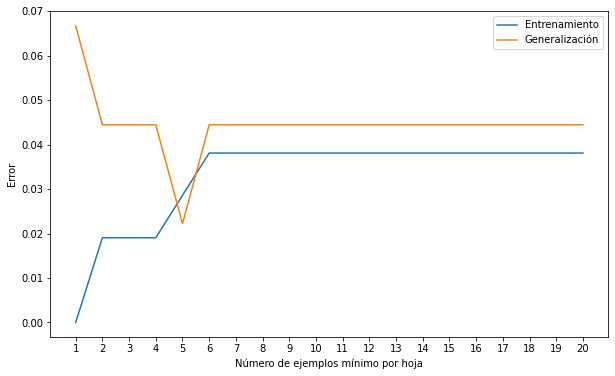

In [ ]:
pl.figure(figsize = (10, 6))

pl.plot(min_samples_leaf_values, train_error, label="Entrenamiento")
pl.plot(min_samples_leaf_values, generalization_error, label="Generalización")
pl.xticks(min_samples_leaf_values)
pl.xlabel("Número de ejemplos mínimo por hoja")
pl.ylabel("Error")
pl.legend();